In [170]:
# Uncomment the line below with you python version
# if this is the first time you are running the notebook

#!pip install category_encoders
#!pip3 install category_encoders

In [171]:
#imports
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 
import category_encoders as ce

from six.moves import urllib
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [172]:
DOWNLOAD_ROOT = "http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening"
CREDIT_DATA_URL = DOWNLOAD_ROOT + "/crx.data"
CREDIT_DATA_PATH = "datasets/credit-screening"

In [173]:
# fetch data from its origin
def fetch_credit_card_data(credit_data_url=CREDIT_DATA_URL, credit_path=CREDIT_DATA_PATH):
    if not os.path.isdir(credit_path):
        os.makedirs(credit_path)
    credit_data_path = os.path.join(credit_path, "crx.data")
    urllib.request.urlretrieve(credit_data_url, credit_data_path)

fetch_credit_card_data()

In [174]:
# load data from csv file 
def load_credit_card_data(credit_data_path=CREDIT_DATA_PATH):
    csv_path=os.path.join(credit_data_path, "crx.data")
    pd.set_option('display.max_columns', None)
    col_names = ["Gender","Age","Debt","Married","BankCustomer","EducationLevel","Ethnicity","YearsEmployed","PriorDefault","Employed","CreditScore", "DriversLicense", "Citizen", "ZipCode", "Income" , "ApprovalStatus"]
    return pd.read_csv(csv_path, header=None, names=col_names)

dataset = load_credit_card_data()
dataframe = dataset.copy()
dataset = dataset.drop(['DriversLicense', 'ZipCode', 'Ethnicity', 'Gender'], axis=1)


In [175]:
# replace question mark with NaN
# replace + and - with 1 and 0
dataset = dataset.replace("?", np.nan).replace('+', 1).replace('-', 0)

# convert age from object to float
dataset = dataset.astype({"Age": float})
#replace missing numeric values with mean

dataset.fillna(dataset.mean(), inplace=True)
dataset.head(5)

# replace missing object values with the most freequent value
for col in dataset:
    if dataset[col].dtypes == 'object':
        dataset = dataset.fillna(dataset[col].value_counts().index[0])

In [176]:
dataset['ApprovalStatus'].value_counts()

0    383
1    307
Name: ApprovalStatus, dtype: int64

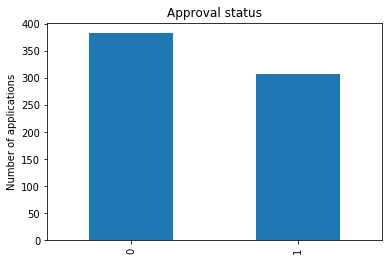

In [177]:
CountStatus = pd.value_counts(dataset['ApprovalStatus'].values, sort=False)
plt.ylabel('Number of applications')
plt.title('Approval status')
CountStatus.plot.bar()

In [178]:
dataset.dtypes

Age               float64
Debt              float64
Married            object
BankCustomer       object
EducationLevel     object
YearsEmployed     float64
PriorDefault       object
Employed           object
CreditScore         int64
Citizen            object
Income              int64
ApprovalStatus      int64
dtype: object

In [179]:
# Label encode for correlation
#le = preprocessing.LabelEncoder()

#labelEncodedSet = dataset.copy()
#for col in dataset:
   # if labelEncodedSet[col].dtypes == 'object':
        #labelEncodedSet[col]=le.fit_transform(labelEncodedSet[col])

#dataset.dtypes

In [180]:
#labelEncodedSet.hist(bins=20, figsize=(20, 15))

In [181]:
#Correlation heatmap
#def make_corr_heatmap(data):
    #corr = data.corr()
    #sns.heatmap(corr, 
                #xticklabels=corr.columns.values,
                #yticklabels=corr.columns.values)

#make_corr_heatmap(labelEncodedSet)

In [182]:
#Correlation with ApprovalStatus
#labelEncodedSet.corr()['ApprovalStatus'].sort_values()

In [183]:
#use MAD to check the spread of the observation from the mean. MAD > std because we have outliers like age, income
#labelEncodedSet.mad()

In [184]:
#drop columns with the lowest correlation, or columns that do not make sense
#dataset = dataset.drop(['DriversLicense', 'ZipCode', 'Ethnicity', 'Gender'], axis=1)
dataset.head()

,Age,Debt,Married,BankCustomer,EducationLevel,YearsEmployed,PriorDefault,Employed,CreditScore,Citizen,Income,ApprovalStatus
0,30.83,0.000,u,g,w,1.25,t,t,1,g,0,1
1,58.67,4.460,u,g,q,3.04,t,t,6,g,560,1
2,24.50,0.500,u,g,q,1.50,t,f,0,g,824,1
3,27.83,1.540,u,g,w,3.75,t,t,5,g,3,1
4,20.17,5.625,u,g,w,1.71,t,f,0,s,0,1


In [185]:
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
dataset = ohe.fit_transform(dataset)
dataset.head()

,Age,Debt,Married_u,Married_y,Married_l,BankCustomer_g,BankCustomer_p,BankCustomer_u,BankCustomer_gg,EducationLevel_w,EducationLevel_q,EducationLevel_m,EducationLevel_r,EducationLevel_cc,EducationLevel_k,EducationLevel_c,EducationLevel_d,EducationLevel_x,EducationLevel_i,EducationLevel_e,EducationLevel_aa,EducationLevel_ff,EducationLevel_j,EducationLevel_u,YearsEmployed,PriorDefault_t,PriorDefault_f,Employed_t,Employed_f,CreditScore,Citizen_g,Citizen_s,Citizen_p,Income,ApprovalStatus
0,30.83,0.000,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.25,1,0,1,0,1,1,0,0,0,1
1,58.67,4.460,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.04,1,0,1,0,6,1,0,0,560,1
2,24.50,0.500,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.50,1,0,0,1,0,1,0,0,824,1
3,27.83,1.540,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.75,1,0,1,0,5,1,0,0,3,1
4,20.17,5.625,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.71,1,0,0,1,0,0,1,0,0,1


In [186]:
#separate the features and labels
dataset = dataset.values
X,y = dataset[:,0:34] , dataset[:,34]

In [187]:
#split the dataset into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [188]:
#rescale the training and testing sets
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = MinMaxScaler()
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)
rescaledX_val = scaler.fit_transform(X_val)

In [189]:
#instantiate the algorithms
rfc = RandomForestClassifier(random_state=42, n_estimators=100)
gnb = GaussianNB()
logreg = LogisticRegression(solver='liblinear')

In [190]:
print("Random Forrest")

roc_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_rfc = cross_val_score(rfc, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()

y_pred_rfc = cross_val_predict(rfc, rescaledX_train, y_train, cv=5)
tn_rfc, fp_rfc, fn_rfc, tp_rfc = confusion_matrix(y_train, y_pred_rfc).ravel()

yi_rfc = 2*roc_rfc-1
yi_rfc_formula = ((tp_rfc/(tp_rfc+fn_rfc)-(1-(tn_rfc/(fp_rfc+tn_rfc)))))

print("AUC: " , roc_rfc)
print("F1: " , f1_rfc)
print("Precission: " , precision_rfc)
print("Recall: " , rec_rfc)
print("Accuracy: " , acc_rfc)
print("Youden's index", yi_rfc)
print("Youden's index formula", yi_rfc_formula)
print("True Negatives: ",tn_rfc)
print("False Positives: ",fp_rfc)
print("False Negatives: ",fn_rfc)
print("True Positives: ",tp_rfc)

Random Forrest
AUC:  0.9160792123392743
F1:  0.839058160647976
Precission:  0.8275687632465851
Recall:  0.8570412517780939
Accuracy:  0.8574786023739918
Youden's index 0.8321584246785485
Youden's index formula 0.7142857142857142
True Negatives:  216
False Positives:  36
False Negatives:  27
True Positives:  162


In [191]:
print("Naive Bayes")

roc_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_gnb = cross_val_score(gnb, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_gnb= cross_val_score(gnb, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()

y_pred_gnb = cross_val_predict(gnb, rescaledX_train, y_train, cv=5)
tn_gnb, fp_gnb, fn_gnb, tp_gnb = metrics.confusion_matrix(y_train,y_pred_gnb).ravel()

yi_gnb = 2*roc_gnb-1
yi_gnb_formula = ((tp_gnb/(tp_gnb+fn_gnb)-(1-(tn_gnb/(fp_gnb+tn_gnb)))))

print("AUC" , roc_gnb)
print("F1: " , f1_gnb)
print("Precission: " , precision_gnb)
print("Recall: " , rec_gnb)
print("Accuracy: " , acc_gnb)
print("Youden's index", yi_gnb)
print("Youden's index formula", yi_gnb_formula)
print("True Negatives: ",tn_gnb)
print("False Positives: ",fp_gnb)
print("False Negatives: ",fn_gnb)
print("True Positives: ",tp_gnb)

Naive Bayes
AUC 0.8645021894959977
F1:  0.5047819461360978
Precission:  0.8648711390910881
Recall:  0.36443812233285916
Accuracy:  0.7029451821586653
Youden's index 0.7290043789919953
Youden's index formula 0.32142857142857145
True Negatives:  241
False Positives:  11
False Negatives:  120
True Positives:  69


In [192]:
print("Logistic regression")

roc_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='roc_auc', cv = 5).mean()
f1_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='f1', cv = 5).mean()
precision_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='precision', cv = 5).mean()
rec_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='recall', cv = 5).mean()
acc_logreg = cross_val_score(logreg, rescaledX_train, y_train, scoring='accuracy', cv = 5).mean()

y_pred_logreg = cross_val_predict(logreg, rescaledX_train, y_train, cv=5)
tn_logreg, fp_logreg, fn_logreg, tp_logreg = metrics.confusion_matrix(y_train, y_pred_logreg).ravel()

yi_logreg = 2*roc_logreg-1
yi_logreg_formula = ((tp_logreg/(tp_logreg+fn_logreg)-(1-(tn_logreg/(fp_logreg+tn_logreg)))))

print("AUC of Logistic Regression is: " , roc_logreg)
print("F1: " , f1_logreg)
print("Precission: " , precision_logreg)
print("Recall: " , rec_logreg)
print("Accuracy: " , acc_gnb)
print("Youden's index", yi_gnb)
print("Youden's index formula", yi_logreg_formula)
print("True Negatives: ",tn_logreg)
print("False Positives: ",fp_logreg)
print("False Negatives: ",fn_logreg)
print("True Positives: ",tp_logreg)

Logistic regression
AUC of Logistic Regression is:  0.9073592725852787
F1:  0.8319986513123767
Precission:  0.7995251161505491
Recall:  0.8726884779516357
Accuracy:  0.7029451821586653
Youden's index 0.7290043789919953
Youden's index formula 0.7023809523809524
True Negatives:  209
False Positives:  43
False Negatives:  24
True Positives:  165
